### Salish Sea Diatoms
Comparing diatom biomass from Salish Sea Cast with values in Atlantis, with an eye to creating a diatom timeseries forcing file if required

In [1]:
import arrow
import os
from datetime import datetime, timedelta
import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
from IPython.display import Image

from salishsea_tools import data_tools, places, nc_tools, wind_tools

In [2]:
# Salish Sea Cast day average diatoms

dfile10 = "/ocean/dlatorne/Atlantis/day-avg-diatoms/SalishSeaCast_day_avg_diatoms_20070101_20070110.nc" #mmol N m-3
dfile30 = "/ocean/dlatorne/Atlantis/day-avg-diatoms/SalishSeaCast_day_avg_diatoms_20070101_20070131.nc"
cfile31 = "/ocean/dlatorne/Atlantis/day-avg-diatoms/SalishSeaCast_day_avg_diatoms_compressed_20070101_20070131.nc"

data10 = xr.open_dataset(str(dfile10), decode_cf=True)
data30 = xr.open_dataset(str(dfile30), decode_cf=True)

In [47]:
diatoms_SSC_tzyx = data30.variables["diatoms"] # [t,z, y, x]

diatoms_SSC_tzy = diatoms_SSC_tzyx.mean(axis=3)
diatoms_SSC_tz = diatoms_SSC_tzy.mean(axis=2)
diatoms_ssc = diatoms_SSC_tz.mean(axis=1)*14 #convert from mmol N m-3 to mg N m-3

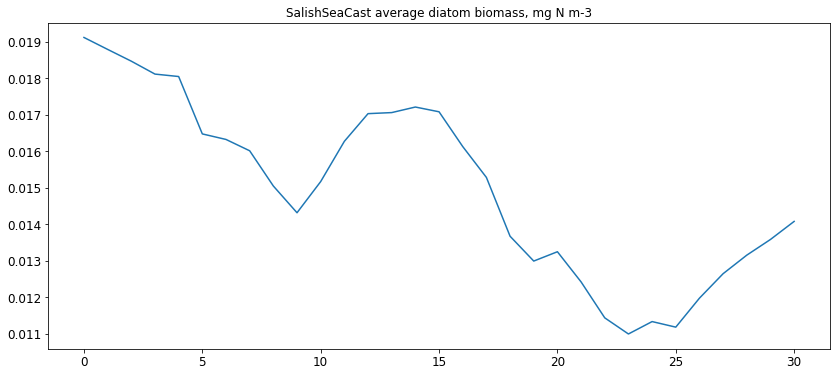

In [48]:
fig, ax = plt.subplots(figsize = (14,6))
ax.plot(diatoms_ssc)
ax.set_title('SalishSeaCast average diatom biomass, mg N m-3', fontsize = 12)
ax.tick_params(labelsize=12)

In [ ]:
# Atlantis diatoms

data_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Control_BF_v6645/outputSalishSea.nc" #mg N m-3
data = xr.open_dataset(str(data_file), decode_cf=True)

diatoms_tbz = np.ma.filled(data.variables["Diatom_N"][:], np.nan)
time = np.ma.filled(data.variables['t'], np.nan)

diatoms_tb = diatoms_tbz.mean(axis=2)
diatoms_ssam = diatoms_tb.mean(axis=1)

In [ ]:
# Comparison Plots

fig, ax = plt.subplots(figsize = (14,3)) 
ax.plot(time, diatoms_ssam, time, diatoms_ssc, '.', linewidth = 2)
ax.set_title('Average diatom biomass', fontsize = 12)
ax.set_ylabel('mg N / m3')
ax.tick_params(labelsize=12)
ax.legend(('SSAM diatoms', 'SSC diatoms'), loc='best');

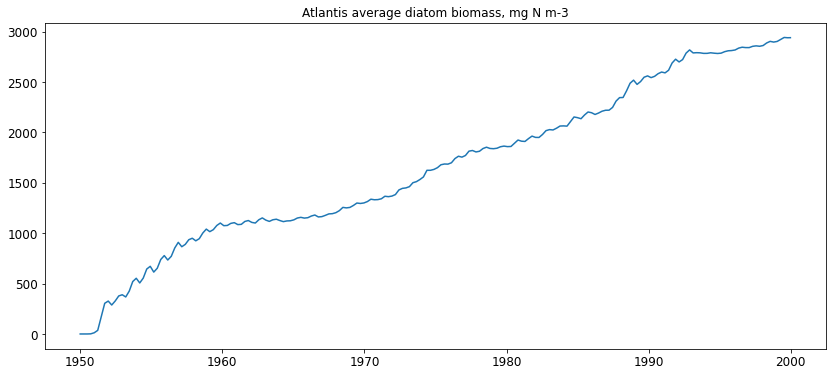

In [ ]:
# Atlantis diatoms

fig, ax = plt.subplots(figsize = (14,6))
ax.plot(time, diatoms_ssam)
ax.set_title('Atlantis average diatom biomass, mg N m-3', fontsize = 12)
ax.tick_params(labelsize=12)

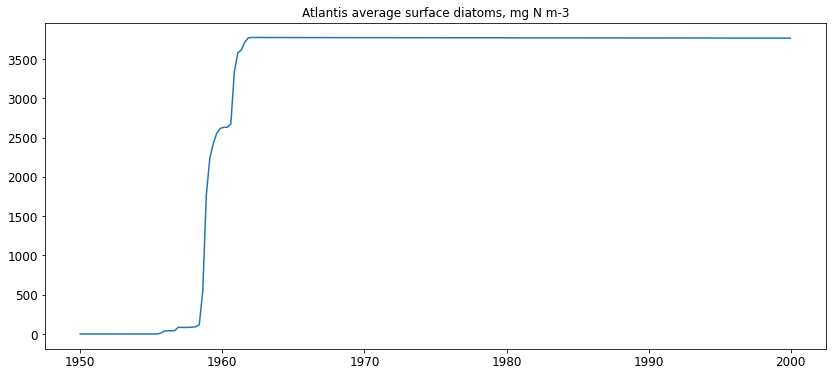

In [45]:
# Atlantis diatoms

data_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Control_BF_v6645/outputSalishSea.nc" #mg N m-3
data = xr.open_dataset(str(data_file), decode_cf=True)

diatoms_tbz = np.ma.filled(data.variables["Diatom_N"][:], np.nan)
time = np.ma.filled(data.variables['t'], np.nan)

diatoms_tb = diatoms_tbz.mean(axis=2)
diatoms_ssam = diatoms_tb.mean(axis=1)

fig, ax = plt.subplots(figsize = (14,6))
ax.plot(time, diatoms_tbz.mean(axis=2)[:,1])
ax.set_title('Atlantis average surface diatoms, mg N m-3', fontsize = 12)
ax.tick_params(labelsize=12)

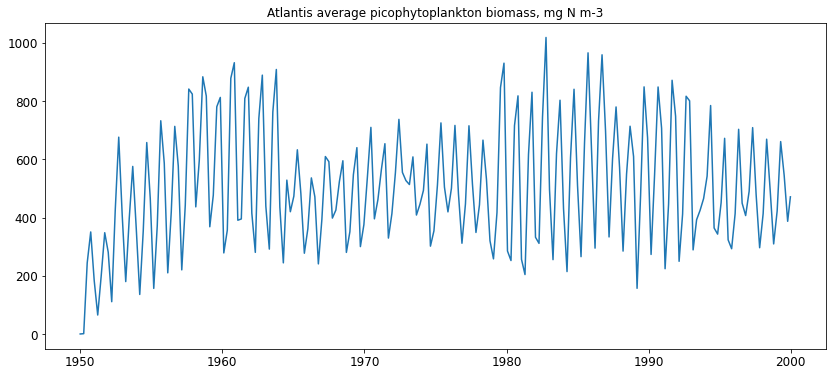

In [35]:
# Atlantis picophytoplankton biomass

picos_tbz = np.ma.filled(data.variables["PicoPhytopl_N"], np.nan)
time = np.ma.filled(data.variables['t'], np.nan)

picos_tb = picos_tbz.mean(axis=2)
picos_ssam = picos_tb.mean(axis=1)

fig, ax = plt.subplots(figsize = (14,6))
ax.plot(time, picos_ssam)
ax.set_title('Atlantis average picophytoplankton biomass, mg N m-3', fontsize = 12)
ax.tick_params(labelsize=12)

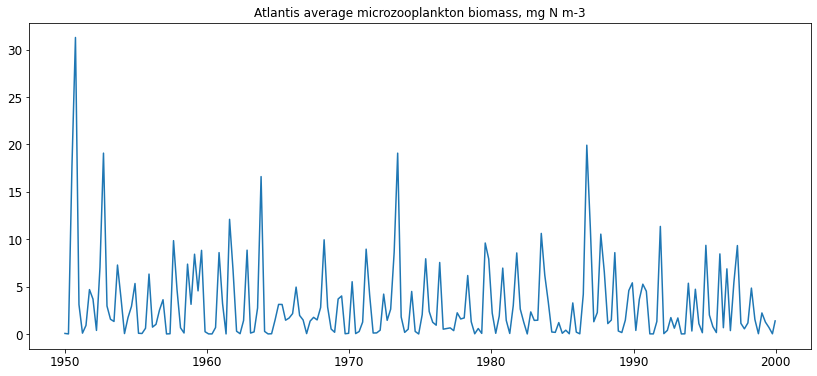

In [19]:
# Atlantis microzooplankton biomass

microzoo_tbz = np.ma.filled(data.variables["MicroZoo_N"], np.nan)

microzoo_tb = microzoo_tbz.mean(axis=2)
microzoo_ssam = microzoo_tb.mean(axis=1)

fig, ax = plt.subplots(figsize = (14,6))
ax.plot(time, microzoo_ssam)
ax.set_title('Atlantis average microzooplankton biomass, mg N m-3', fontsize = 12)
ax.tick_params(labelsize=12)